<a href="https://colab.research.google.com/github/hieuza/fun/blob/main/jax_jit_and_jax_vmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compare vmap, jit a vmap'ed and vmap a jit.

Conclusion:
jit a vmap'ed > vmap a jit'ed >> vmap >> Python loop

See the plot below.
Why jit a vmap'ed is fastest? Because the fixed batch-size and input argument shapes are complied. It must be re-compiled for different batch-size and may be sub-optimal if the compilation time is more than function computation time.

Inspired by: https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html

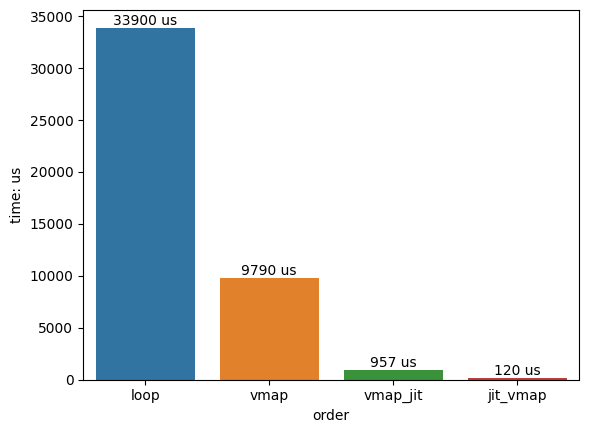

In [51]:
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline
time_us = {'loop': 33900, 'vmap': 9790, 'vmap_jit': 957, 'jit_vmap': 120}

ax = sbn.barplot(x=list(time_us.keys()), y=list(time_us.values()))
for idx, value in enumerate(time_us.values()):
  ax.text(idx, value, f'{value} us', ha='center', va='bottom')

plt.xlabel('order')
plt.ylabel('time: us')
plt.show()

# Common data

In [40]:
import jax
import jax.numpy as jnp

x = jnp.arange(5, dtype=jnp.float32)
w = jnp.array([2, 3, 4], dtype=jnp.float32)

xs = jnp.vstack([x] * 5)

# Loop

In [44]:
def convolve(x, w):
  # print('convolve', x)
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

# loop
def loop_convolve(x, w):
  result = []
  for i in range(x.shape[0]):
    result.append(convolve(x[i], w))
  return jnp.vstack(result)

%timeit -r10 -n100 loop_convolve(xs, w).block_until_ready()

33.9 ms ± 3.52 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


#Only vmap

In [41]:
def convolve(x, w):
  # print('convolve', x)
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

# no jit
v_convolve = jax.vmap(convolve, in_axes=[0, None])
v_convolve(xs, w)
%timeit -r10 -n100 v_convolve(xs, w).block_until_ready()

11.2 ms ± 2.82 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


# vmap a jit'ed

In [42]:
@jax.jit
def convolve(x, w):
  # print('convolve', x)
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)
# vmap a jit'ed
vj_convolve = jax.vmap(convolve, in_axes=[0, None])
vj_convolve(xs, w)
%timeit -r10 -n100 vj_convolve(xs, w).block_until_ready()

1.22 ms ± 153 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


#jit a vmap'ed

In [43]:
def convolve(x, w):
  # print('convolve', x)
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

# no jit
jv_convolve = jax.jit(jax.vmap(convolve, in_axes=[0, None]))
jv_convolve(xs, w)
%timeit -r10 -n100 jv_convolve(xs, w).block_until_ready()

206 µs ± 37.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
